In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels.api

df1 = pd.read_csv(r'/Users/guillaumeblais/Documents/GitHub/Pyrefighter/LFB+Incident+data+from+January+2017.csv', sep = ';')
df2 = pd.read_csv(r'/Users/guillaumeblais/Documents/GitHub/Pyrefighter/LFB+Mobilisation+data+from+January+2017.csv', sep = ';')
df3 = pd.read_csv(r'/Users/guillaumeblais/Documents/GitHub/Pyrefighter/CoordoneesFireStations.csv')

df = df2.merge(df1, on = 'IncidentNumber')
df = df3.merge(df, on = 'DeployedFromStation_Name', suffixes=['', '_'])
df = df[['IncidentNumber', 'CalYear', 'IncidentGroup','PropertyCategory', 'AddressQualifier', 'IncGeo_BoroughName', 
         'Easting_rounded', 'Northing_rounded', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation',
         'DateAndTimeMobilised', 'DateAndTimeMobile','DateAndTimeArrived', 'DeployedFromStation_Name','DeployedFromLocation', 
         'PumpOrder', 'DelayCode_Description','Latitude', 'Longitude']]


#  Création de la variable cible 'ResponseTimeMinute'
df['DateAndTimeMobilised'] = pd.to_datetime(df['DateAndTimeMobilised'])
df['DateAndTimeArrived'] = pd.to_datetime(df['DateAndTimeArrived'])

# Nettoyage de la variable cible
# On supprime les incidents pour lesquels le temps de réponse est négatif ou supérieur à 1h (60 min)
df['ResponseTimeMinute'] = (df['DateAndTimeArrived'] - df['DateAndTimeMobilised']).dt.total_seconds()/60
df = df[(df['ResponseTimeMinute'] > 0) & (df['ResponseTimeMinute'] < 60)]

# Création des variables 'HourMobilised', 'WeekdayMobilised', 'MonthMobilised'
df['HourMobilised'] = pd.to_datetime(df['DateAndTimeMobilised']).dt.hour
df['WeekdayMobilised'] = pd.to_datetime(df['DateAndTimeMobilised']).dt.weekday
df['MonthMobilised'] = pd.to_datetime(df['DateAndTimeMobilised']).dt.month

df.head()

/Users/guillaumeblais/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,IncidentNumber,CalYear,IncidentGroup,PropertyCategory,AddressQualifier,IncGeo_BoroughName,Easting_rounded,Northing_rounded,IncidentStationGround,FirstPumpArriving_DeployedFromStation,...,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,DelayCode_Description,Latitude,Longitude,ResponseTimeMinute,HourMobilised,WeekdayMobilised,MonthMobilised
0,000006-01012017,2017,Fire,Non Residential,Correct incident location,BARKING AND DAGENHAM,544650,184550,Barking,Barking,...,Barking,Home Station,1,NaN,51.529581,0.090057,5.0,0,6,1
1,000285-01012017,2017,Fire,Dwelling,Correct incident location,BARKING AND DAGENHAM,546150,182450,Barking,Barking,...,Barking,Home Station,1,NaN,51.529581,0.090057,4.0,13,6,1
2,000520-02012017,2017,Fire,Road Vehicle,In street close to gazetteer location,BARKING AND DAGENHAM,544250,184750,Barking,Barking,...,Barking,Home Station,1,NaN,51.529581,0.090057,5.0,2,2,2
3,000521-02012017,2017,False Alarm,Road Vehicle,In street outside gazetteer location,REDBRIDGE,544150,184850,Barking,Barking,...,Barking,Home Station,1,NaN,51.529581,0.090057,6.0,2,2,2
4,000545-02012017,2017,Fire,Outdoor Structure,On land associated with building,BARKING AND DAGENHAM,546850,183850,Barking,Barking,...,Barking,NaN,1,NaN,51.529581,0.090057,5.0,4,2,2


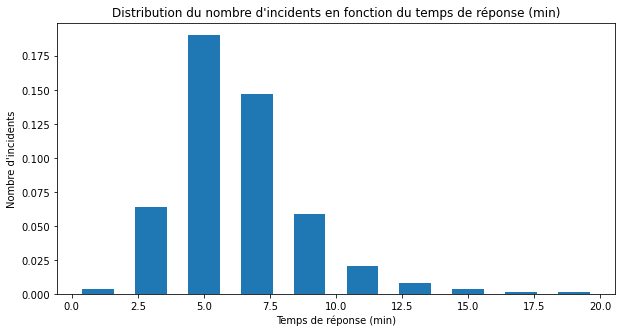

In [5]:
# Visualisation du temps de réponse
plt.figure(figsize=(10,5))
plt.hist(df['ResponseTimeMinute'], density = True, rwidth = 0.6, range = (0,20))
plt.xlabel('Temps de réponse (mins)')
plt.ylabel('Nombre d\'incidents')
plt.title('Distribution du nombre d\'incidents en fonction du temps de réponse (mins)');
# Le temps de d'intervention des pompiers est majoritairement compris entre 3 et 8 min. La prédiction du temps de réponse doit donc être de l'ordre de la minute.

,df,sum_sq,mean_sq,F,PR(>F)
HourMobilised,1.0,2.389315e+03,2389.314997,388.531602,1.840730e-86
Residual,600129.0,3.690555e+06,6.149603,NaN,NaN


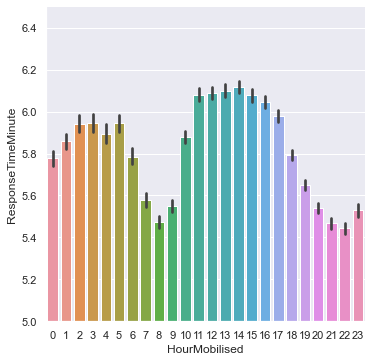

In [35]:
# Visualisation du temps de réponse en fonction de l'heure de la journée

sns.catplot(x = 'HourMobilised', y = 'ResponseTimeMinute', kind = 'bar', data = df);
plt.ylim(5,6.5)

# Relation avec la variable cible

# Hypothèse HourMobilised n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ HourMobilised', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# Le temps de réponse le plus faible est atteint à 8h, ce temps augmente jusqu'à 14h pour atteindre sa valeur maximale puis diminue jusqu'à 22h pour réaugmenter et 
# atteindre un second pic vers 5h du matin.
# Le temps de réponse maximum est atteint à 14h, ce temps de réponse diminue jusqu'à 22h.

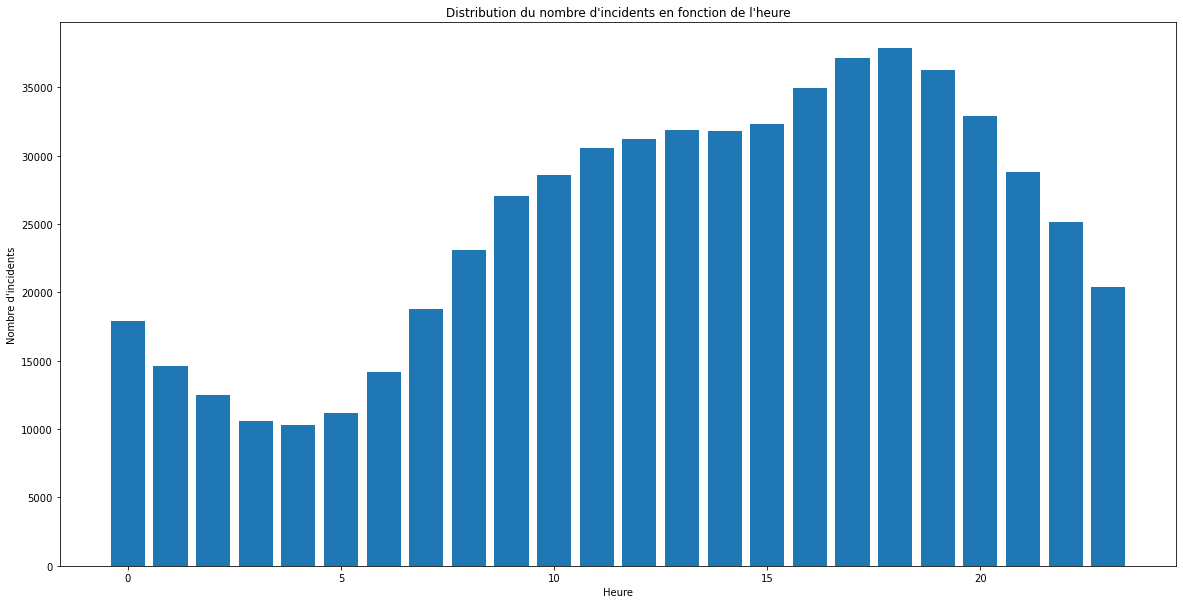

In [7]:
incident_per_hour = df.groupby('HourMobilised', as_index = False).agg({'IncidentNumber':'count'})
# incident_per_hour
plt.figure(figsize=(20,10))
plt.bar(incident_per_hour['HourMobilised'],incident_per_hour['IncidentNumber'])
plt.xlabel('Heure')
plt.ylabel('Nombre d\'incidents')
plt.title('Distribution du nombre d\'incidents en fonction de l\'heure');

,df,sum_sq,mean_sq,F,PR(>F)
WeekdayMobilised,1.0,2.664436e+00,2.664436,0.43299,0.510526
Residual,600129.0,3.692942e+06,6.153580,NaN,NaN


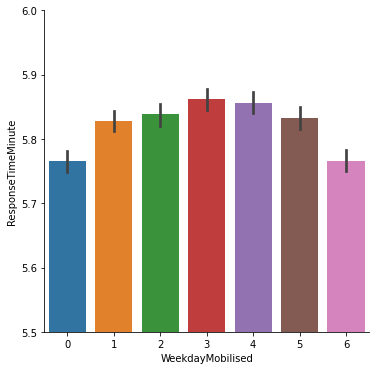

In [24]:
# Visualisation du temps de réponse en fonction du jour de la semaine

sns.catplot(x = 'WeekdayMobilised', y = 'ResponseTimeMinute', kind = 'bar', data = df);
plt.ylim(5.5,6)

# Relation avec la variable cible

# Hypothèse WeekdayMobilised n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ WeekdayMobilised', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est supérieure à 5% donc on n'accepte pas l'hypothèse nulle. Les 2 variables sont indépendantes.

,df,sum_sq,mean_sq,F,PR(>F)
MonthMobilised,1.0,1.304134e+01,13.041340,2.119316,0.145452
Residual,600129.0,3.692931e+06,6.153562,NaN,NaN


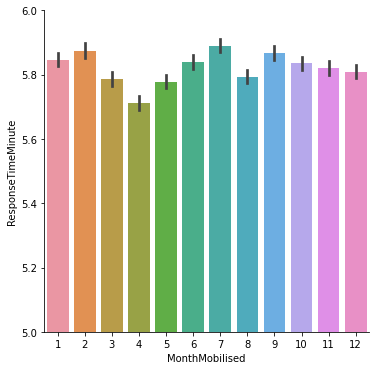

In [9]:
# Visualisation du temps de réponse en fonction de l'heure de la journée

sns.catplot(x = 'MonthMobilised', y = 'ResponseTimeMinute', kind = 'bar', data = df);
plt.ylim(5.5,6)
# Relation avec la variable cible

# Hypothèse MonthMobilised n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ MonthMobilised', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est supérieure à 5% donc on valide l'hypothèse. Les 2 variables sont indépendantes.

(5.0, 6.5)

<Figure size 1440x720 with 0 Axes>

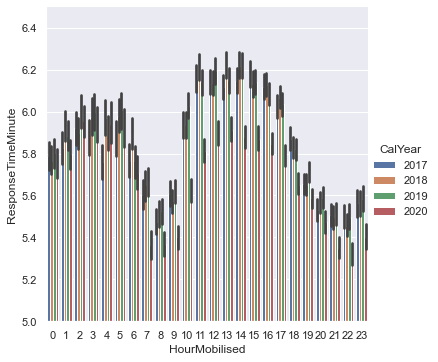

In [33]:
# Visualisation du temps de réponse en fonction de l'heure de la journée et par année
sns.catplot(x = 'HourMobilised', y = 'ResponseTimeMinute', kind = 'bar', hue = 'CalYear', data = df);
plt.ylim(5,6.5)

# On observe qu'en majorité le temps de réponse le plus faible était en 2020 à chaque moment de la journée.

(5.0, 6.5)

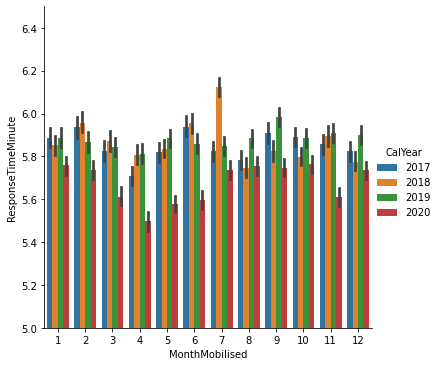

In [11]:
# Visualisation du temps de réponse en fonction du mois et par année

sns.catplot(x = 'MonthMobilised', y = 'ResponseTimeMinute', kind = 'bar', hue = 'CalYear', data = df);
plt.figure(figsize=(20,10))
plt.ylim(5,6.5)

# On observe que le temps de réponse moyen est systématiquement plus faible à chaque mois de l'année en 2020.
# On observe également que la différence est plus importante pour les mois d'avril, mai et novembre, mois de l'année pendant
# lesquels la ville de Londres était complètement confinée.

,df,sum_sq,mean_sq,F,PR(>F)
PropertyCategory,8.0,3.383600e+04,4229.499913,693.670637,0.0
Residual,600122.0,3.659108e+06,6.097274,NaN,NaN


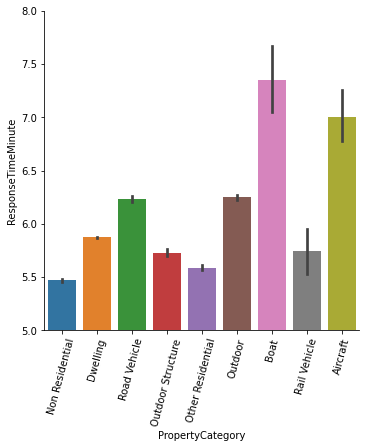

In [12]:
# Visualisation du temps de réponse en fonction du type de propriété
viz = sns.catplot(x = 'PropertyCategory', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=75)
plt.ylim(5,8)
# Relation avec la variable cible

# Hypothèse PropertyCategory n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ PropertyCategory', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe que lorsqu'un incident a lieu dans un bateau ou un avion, le temps de réponse est plus élevé.

,df,sum_sq,mean_sq,F,PR(>F)
AddressQualifier,10.0,4.980425e+04,4980.425413,820.405724,0.0
Residual,600120.0,3.643140e+06,6.070686,NaN,NaN


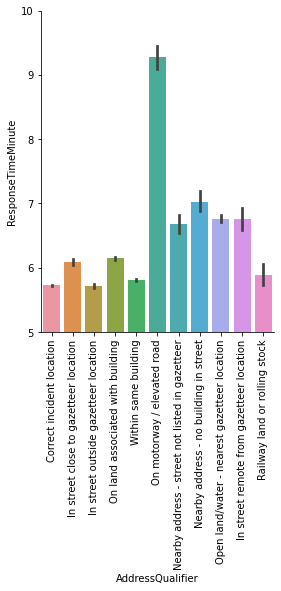

In [13]:
# Visualisation du temps de réponse en fonction de l'exactitude de l'adresse
viz = sns.catplot(x = 'AddressQualifier', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)
plt.ylim(5,10)

# Relation avec la variable cible

# Hypothèse AddressQualifier n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ AddressQualifier', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe que le temps de réponse le plus faible est obtenue lorsque l'adresse est correcte.
# Par ailleurs, le temps de réponse le plus long est obtenu lorsque l'incident se trouve sur une autoroute ou une route
# surélevée. En effet, il est plus difficile d'indiquer une localisation précise sur ce types de lieu.

,df,sum_sq,mean_sq,F,PR(>F)
IncGeo_BoroughName,32.0,1.126402e+05,3520.007652,589.991675,0.0
Residual,600098.0,3.580304e+06,5.966199,NaN,NaN


<Figure size 1440x720 with 0 Axes>

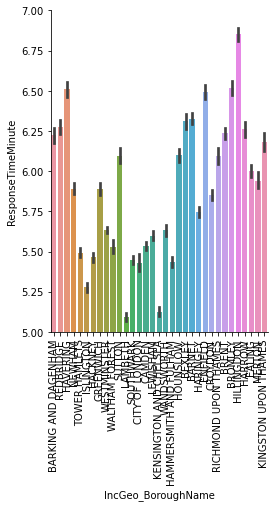

In [26]:
# Visualisation du temps de réponse en fonction de l'arrondissement où l'incident a eu lieu
plt.figure(figsize=(20,10))
viz = sns.catplot(x = 'IncGeo_BoroughName', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)
plt.ylim(5,7)

# Relation avec la variable cible

# Hypothèse IncGeo_BoroughName n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ IncGeo_BoroughName', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe qu'il y a une différence de temps d'intervention en fonction des arrondissements.

,df,sum_sq,mean_sq,F,PR(>F)
CityCenter,1.0,7.292207e+04,72922.070409,12089.055566,0.0
Residual,600129.0,3.620022e+06,6.032073,NaN,NaN


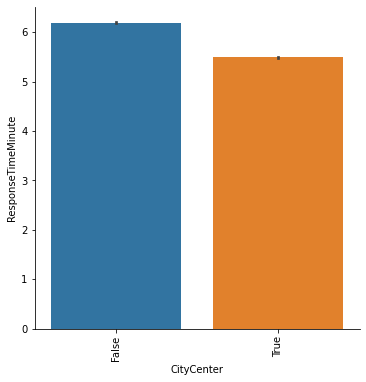

In [15]:
# Visualisation du temps de réponse en fonction de la localisation de l'incident centre ville/périphérie
CityCenter = ['ISLINGTON', 'WESTMINSTER', 'HARINGEY', 'SOUTHWARK', 'TOWER HAMLETS', 'HACKNEY', 'NEWHAM', 'LAMBETH', 'CAMDEN',
               'WANDSWORTH', 'LEWISHAM', 'CITY OF LONDON', 'KENSINGTON AND CHELSEA', 'HAMMERSMITH AND FULHAM']

Peripherie = ['GREENWICH', 'BARKING AND DAGENHAM', 'EALING', 'BRENT', 'REDBRIDGE', 'CROYDON', 'HARROW', 'ENFIELD', 'BROMLEY',
              'BEXLEY', 'HAVERING', 'MERTON', 'HOUNSLOW', 'BARNET', 'HILLINGDON', 'SUTTON', 'WALTHAM FOREST', 
              'KINGSTON UPON THAMES', 'RICHMOND UPON THAMES']

# print(df['IncGeo_BoroughName'][0])

df['CityCenter'] = df['IncGeo_BoroughName'].apply(lambda x: x in CityCenter)
# df.head()

viz = sns.catplot(x = 'CityCenter', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90);

# Relation avec la variable cible

# Hypothèse CityCenter n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ CityCenter', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe que le temps de réponse est plus faible lorsque l'incident a lieu en centre ville.

,df,sum_sq,mean_sq,F,PR(>F)
IncidentStationGround,101.0,1.592097e+05,1576.333566,267.661829,0.0
Residual,600029.0,3.533735e+06,5.889273,NaN,NaN


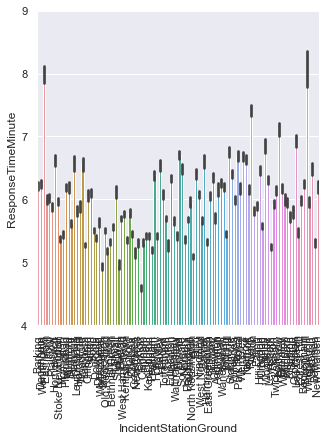

In [34]:
# Visualisation du temps de réponse en fonction de la caserne responsable de la zone d'incident
viz = sns.catplot(x = 'IncidentStationGround', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)
plt.ylim(4,9)

# Relation avec la variable cible

# Hypothèse 'IncidentStationGround' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ IncidentStationGround', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.

,df,sum_sq,mean_sq,F,PR(>F)
FirstPumpArriving_DeployedFromStation,103.0,1.238806e+05,1202.724682,202.202226,0.0
Residual,600019.0,3.568990e+06,5.948128,NaN,NaN


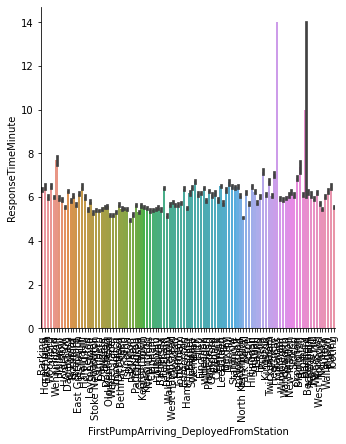

<Figure size 1440x720 with 0 Axes>

In [17]:
# Visualisation du temps de réponse en fonction du 1er camion arrivé sur les lieux
viz = sns.catplot(x = 'FirstPumpArriving_DeployedFromStation', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)


# Relation avec la variable cible

# Hypothèse 'FirstPumpArriving_DeployedFromStation' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ FirstPumpArriving_DeployedFromStation', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.

,df,sum_sq,mean_sq,F,PR(>F)
DeployedFromStation_Name,101.0,1.152493e+05,1141.082656,191.37537,0.0
Residual,600029.0,3.577695e+06,5.962537,NaN,NaN


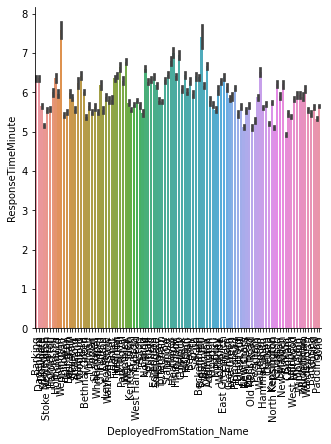

<Figure size 1440x720 with 0 Axes>

In [18]:
# Visualisation du temps de réponse en fonction de la caserne déployée
viz = sns.catplot(x = 'DeployedFromStation_Name', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)

# Relation avec la variable cible

# Hypothèse 'DeployedFromStation_Name' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ DeployedFromStation_Name', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.

,df,sum_sq,mean_sq,F,PR(>F)
DeployedFromLocation,1.0,7.381904e+03,7381.904260,1202.624473,2.998218e-263
Residual,599698.0,3.681044e+06,6.138162,NaN,NaN


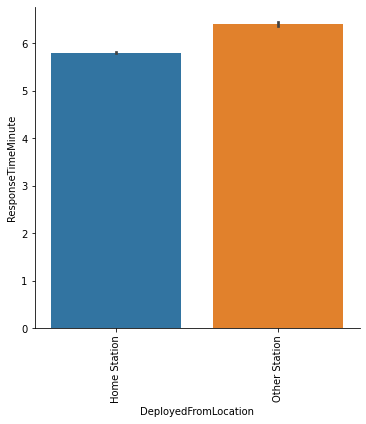

In [19]:
# Visualisation du temps de réponse en fonction du lieu de déploiement de la brigade
viz = sns.catplot(x = 'DeployedFromLocation', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)

# Relation avec la variable cible

# Hypothèse 'DeployedFromLocation' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ DeployedFromLocation', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe que le temps de réponse est plus faible lorsque la brigade se trouve à leur caserne lors de l'appel (97% des cas).

,df,sum_sq,mean_sq,F,PR(>F)
DelayCode_Description,9.0,22318.894988,2479.877221,447.823297,0.0
Residual,136205.0,754252.132843,5.537624,NaN,NaN


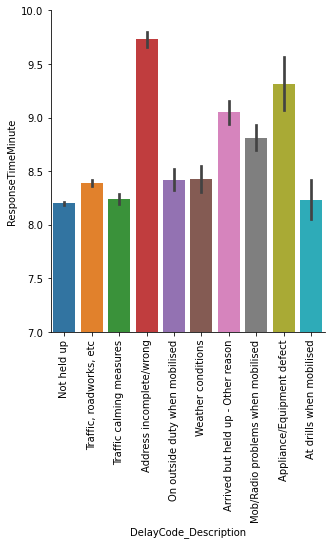

In [20]:
# Visualisation du temps de réponse en fonction de la raison de retard
viz = sns.catplot(x = 'DelayCode_Description', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)
plt.ylim(7,10)

# Relation avec la variable cible

# Hypothèse 'DelayCode_Description' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ DelayCode_Description', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# Lorsqu'un retard est déclaré sur l'intervention, la raison qui provoque le retard le plus important est une adresse 
# incomplète ou incorrecte.
# Il est donc primordial d'obtenir la localisation la plus exacte possible de la part de la personne qui appelle.

,df,sum_sq,mean_sq,F,PR(>F)
IncidentGroup,2.0,9.719983e+03,4859.991414,791.865149,0.0
Residual,600128.0,3.683224e+06,6.137398,NaN,NaN


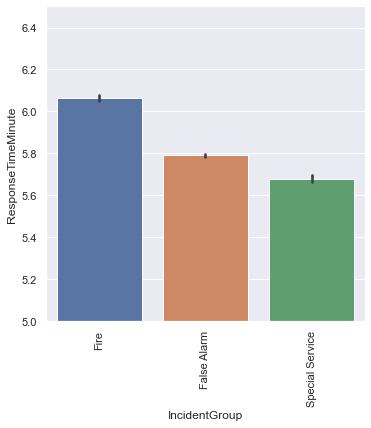

In [36]:
# Visualisation du temps de réponse en fonction du type d'incident
viz = sns.catplot(x = 'IncidentGroup', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)
plt.ylim(5,6.5)

# Relation avec la variable cible

# Hypothèse 'IncidentGroup' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ IncidentGroup', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe que le temps de réponse est plus long lorsqu'il s'agit d'un incendie.

,df,sum_sq,mean_sq,F,PR(>F)
PumpOrder,1.0,5.064625e+05,506462.535109,95385.093219,0.0
Residual,600129.0,3.186482e+06,5.309661,NaN,NaN


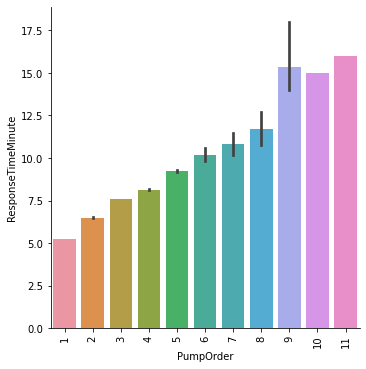

In [22]:
# Visualisation du temps de réponse en fonction du nombre de camions demandés
viz = sns.catplot(x = 'PumpOrder', y = 'ResponseTimeMinute', kind = 'bar', data = df)
viz.set_xticklabels(rotation=90)

# Relation avec la variable cible

# Hypothèse 'PumpOrder' n'influe pas sur ResponseTimeMinute
result = statsmodels.formula.api.ols('ResponseTimeMinute ~ PumpOrder', data = df).fit()
table = statsmodels.api.stats.anova_lm(result)
table
# Conclusion : la p-value (PR(>F)) est inférieure à 5% donc on rejette l'hypothèse. Les 2 variables ne sont pas indépendantes.
# On observe que plus le nombre de camions demandés est grand, plus le temps de réponse est important.
# Limites : pour la grande majorité des incidents, seuls 1 ou 2 camions interviennent (Ex : 1 seul incident avec 11 camions)